# Deep Learning a PDE with PINNs (Worst of Options)

This notebook is an extension of [Deep Learning a PDE with PINNs](https://colab.research.google.com/drive/1cYkeG2EEnZw8iCguXlnCSAbI1vJBtfpZ?usp=sharing#scrollTo=3Cy273l7ZPCb) where we applied Physics Informed Neural Networks (PINNs) to the case of a 1-asset call option.

Our previous work was largely inspired by [J. Blechschmidt, O. G. Ernst](https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006) who provide an excellent starting point in 1 dimension. We previously adapted the code to financial applications with a study of the Greeks and comparison against closed-forms. Exotic options (up-and-out barriers) in 1 dimension have been considered in [T. Toh](https://github.com/timotito/optionsPINN/) where it is argued that the PINNs represent a promising solution for market makers due to their ability to price very quickly after training has been front-loaded.

In the present work we are interested in increasing the dimension of the problem. We introduce a multi-asset set up that can value worst-of basket options on a generic number of (correlated) underlyings. Deep Learning methods have been proposed as solutions to the infamous "curse of dimensionality" where the resolution time increases exponentially with the dimension of the problem. The Finite Different Method (FDM) typically suffers from this issue so severely that it is difficult to use it in more than 3 dimensions. Typical applications that we have seen in practice are in 1 dimension, possibly in 2 dimensions, but when reaching 3 dimensions, the method of choice tends to switch to Monte-Carlo, which in turns suffers from other issues (slow convergence especially for Greeks, difficulties with callable products, etc.).

In contrast to the FDM, Deep Learning methods such as the PINNs are considered as good candidates to beat the curse of dimensionality, with a runtime growing at a more pratical rate with the increasing dimension. In this work we want to test this hypothesis by observing the behaviour of the PINNs in the multi-dimensional set-up of basket options with the worst-of performance feature.

Notable changes/improvements over the previous work include:

* extension to generic multi-asset configurations with correlations
* comparison of values for PV, theta, deltas, gammas and cross-gammas against Monte-Carlo
* possibility for the user to download pre-trained models
* introduction of a custom learning rate schedule to improve convergence of the training.

This work is not meant to probe dimensions to very high levels (yet?). For now, we would like to see if the PINNs can at least succeed where the FDM becomes impractical, i.e. beyond 3~4 dimensions, and whether there is a hope that the curse of dimensionality can be tamed or not. 

Having tested the models from 2 to 5 dimensions, our main conclusions and findings are the following:

* good accuracies can be reached over the studied range of dimensions, and the runtime necessary to stay at a relatively similar level of error increases moderately with the dimension. This study being preliminary and on-going it is hard to give a definite conclusion, but our current test results show an increase that is worse than linear but much better exponential, thereby lending plausibility to the hopes that Deep Learning methods might indeed sucessfully address the curse of dimensionality (far more work is necessary to gain more statistical confidence in such conclusions).
* in more details, we find no real need to increase the number of hidden layers and/or neurons per layer as the dimension of the problem increases. Similarly, at least after introducing our custom learning schedule, we also find little need to change other hyperparameters such as the learning rates or number of epochs.
* we find an interesting interplay between the loss that we are trying to minimize (essentially the error on the PDE and its boundaries) and the RMSE against Monte-Carlo. Networks that are very suboptimal as far as the loss is concerned, can be quite accurate on the RMSE. However, this situation is unstable, and continuing the training leads to further decrease of the loss, where the RMSE increases, before decreasing again in a stable way when finding the true solution.

Nevertheless, as the readers can experiment with the notebook, training takes a significant time already in 2 dimensions. We suspect, however, that Deep Learning specialists (we are not among them) may be able to do much better. We very much encourage our readers to experiment with this notebook and inform us if they can find improvements, possibly using more advanced network structures or training algorithms we are not aware of. Meanwhile, we are continuing to accumulate sample trained models, analyse their statistical performance and increase the dimension.

In [1]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as tm
import scipy.stats
import sklearn as sk
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
from platform import python_version
import os

print("Python version: " + python_version())
print("TensorFlow version: " + tf.__version__)
print("TF-Keras version: " + tf.keras.__version__)
print("TF-Probability version: " + tfp.__version__)
print("NumPy version: " + np.__version__)
print("SciPy version: " + scipy.__version__)
print("SciKit version: " + sk.__version__)

Python version: 3.8.10
TensorFlow version: 2.11.0
TF-Keras version: 2.11.0
TF-Probability version: 0.19.0
NumPy version: 1.22.4
SciPy version: 1.7.3
SciKit version: 1.0.2


## 1) Preparation

In this section we take preliminary steps such as setting up parameters, defining helper functions and downloading pre-trained models (optional).

### a) Loading pre-trained models

This step is optional, only necessary if you choose to use pre-trained model rather than training them here.

We trained series of models with various configurations and hyper-parameters as well as random seeds to analyse the performance from a statistical standpoint. The models were all trained on a set of payoff and market data scenarios given in this notebook. Therefore these pre-trained model should be compared against Monte-Carlo with the same payoffs/market data. If you intend to change the payoff specifications or the market data, you should instead train new models, which is also possible in this notebook.

To load the pre-trained models, first download the zip file containing the trained models from the link [pre-trained models](https://drive.google.com/file/d/1-sUWSXCiaJSnLJySMfdBnDkHoXZ-jiEW/view?usp=sharing). Then click the icon "Upload to session storage" at the top of the Files tab of the left pane, as highlighted in yellow below

<img src='https://drive.google.com/uc?id=1-_G1c0ibiOh6gJSGY4N_7LTzMIXp6x96' width=300>

and upload the zip file. Finally execute the cell below, after setting use_saved_models to True. It will unzip into a Colab online folder containing all the trained models.

In [90]:
# If set to true, use saved models to compare against MC
use_saved_models = False
trained_model_folder = "/content/sdev.python/models"

if use_saved_models:
    !mkdir -p sdev.python/models
    !unzip -u "/content/sdev.python-pinns_worst_of.zip" -d sdev.python/models

### b) Payoff and market data

Here we give the payoff specifications (number of assets, fixings, cap, floor, expiry). We then specify market data (spot, volatilities, dividends, rates), and finally, the correlations. For simplicity the correlation is taken with a very simple structure based on one correlation parameters, but nothing prevents us from taking a more complex matrix, so long as it is positive-definite.

The number of assets is implied from the size of the input vectors. The examples of parameters in the cell below correspond to the pre-trained models, but these parameters can be changed, in which case the models need to be re-trained.

In [91]:
# Payoff and model parameters
dtype = 'float64'
tf.keras.backend.set_floatx(dtype)
# 2D
spot = np.asarray([100, 105], dtype=dtype)
vol = np.asarray([0.25, 0.35], dtype=dtype)
div = np.asarray([0.02, 0.01], dtype=dtype)
fixings = np.asarray([90, 95], dtype=dtype)  # Past value of the spot to measure performance
model_name = "model_2_assets"
# 3D
# spot = np.asarray([100, 105, 102], dtype=dtype)
# vol = np.asarray([0.25, 0.35, 0.30], dtype=dtype)
# div = np.asarray([0.02, 0.01, 0.01], dtype=dtype)
# fixings = np.asarray([90, 95, 92], dtype=dtype)  # Past value of the spot to measure performance
# model_name = "model_3_assets"
# 4D
# spot = np.asarray([100, 105, 102, 104], dtype=dtype)
# vol = np.asarray([0.25, 0.35, 0.30, 0.40], dtype=dtype)
# div = np.asarray([0.02, 0.01, 0.01, 0.03], dtype=dtype)
# fixings = np.asarray([90, 95, 92, 97], dtype=dtype)  # Past value of the spot to measure performance
# model_name = "model_4_assets"
# 5D
# spot = np.asarray([100, 105, 102, 104, 103], dtype=dtype)
# vol = np.asarray([0.25, 0.35, 0.20, 0.40, 0.30], dtype=dtype)
# div = np.asarray([0.02, 0.01, 0.02, 0.03, 0.025], dtype=dtype)
# fixings = np.asarray([90, 95, 92, 97, 102], dtype=dtype)  # Past value of the spot to measure performance
# model_name = "model_5_assets"

rate = 0.015
expiry = 2.5
floor = -10.0 / 100  # -1.5 / 100  # Flooring the worst performance
cap = 10.0 / 100  # Capping the best performance
notional = 10000.0  # 10 * 1000
num_assets = len(spot)
# Correlation matrix
correlation = 0.50
correl = np.ones((num_assets, num_assets), dtype=dtype) * correlation
for i in range(num_assets):
    correl[i, i] = 1.0
# Covariance matrix
cov = correl.copy()
for i in range(len(correl)):
    for j in range(len(correl)):
        cov[i, j] *= vol[i] * vol[j]

# Random generator seed
seed = 42

print("Number of assets: " + str(num_assets))
print("Correlation: " + str(correlation * 100) + "%")

Number of assets: 2
Correlation: 50.0%


### c) Helper functions

We implement a number of helper functions including a payoff smoother to help the convergence of the Monte-Carlo Greeks.

In [92]:
# Print vector
def print_vec(name, data):
    print(name + ": [", end=""),
    for i in range(len(data)):
        print("{:,.2f}".format(data[i]), end="")
        if i < len(data) - 1:
            print(", ", end="")
    print("]")

# Smoothing parameters (for the max function)
smooth_vol = 0.02
smooth_time = 10.0 / 365.0
smooth_stdev = smooth_vol * np.sqrt(smooth_time)
s2p = np.sqrt(2.0 * np.pi)
tf_N = tfp.distributions.Normal(0.0, 1.0)

# Tensorflow implementation of the payoff smoother ('tf_smooth_max')
def tf_approx_cdf(x):
    return 1.0 / (1.0 + tf.math.exp(-x / 0.5879))

# Tensorflow implementation of normal smoother
def tf_smooth_max(x, y):
    d1 = (x - y) / smooth_stdev
    # N1 = tf_N.cdf(d1)  # There was a problem with the one below for AD, but this one has a problem for float64
    N1 = tf_approx_cdf(d1)  # Older
    return (x - y) * N1 + 0.5 * smooth_stdev * tf.math.exp(-0.5 * tf.math.pow(d1, 2)) / s2p

## 2) PINN learning

In this section we implement the PDE solving using a PINN. The main idea is to consider the resolution of the PDE as an optimization problem, where the loss function receives two contributions: the PDE (i.e. an equation with a 0 right-hand side) and its boundaries (i.e. a collection of payoff evaluations at points in space and time that are relevant to the problem).

The network's inputs are points with 1 dimension for time plus 1 dimension per asset. We draw two different types of points: the inner points and the boundaries. The network's output is the derivative's PV as a function of time and space. That is, the network gives us the PV not just for spot at $t=0$ but for any point in time and at any value of the spots between $t=0$ and maturity.

The loss function is a combination of a PDE contribution, targetting 0, and a boundary contribution where the target PV is assumed to be known. This is typically the case of the payoff at maturity, which can be augmented by "side boundaries" at earlier times but with extreme values of the spots (in a very similar fashion to the standard Finite Difference Method).

In this section we only define the methods necessary for the training and evaluation of the model. The actual training is triggered later by coupling all these building blocks.

### a) Payoff and side boundaries

We start by defining the range of variation of our points. Time varies between 0 and maturity. The spot assets are modelled as log-forward-moneyness, and we set their range by a certain percentile of their (marginal) distributions at maturity. Note that we only define the ranges here, we are not yet defining the points themselves.

In [93]:
# Time boundaries at 0 and expiry
tmin = tf.constant(0.0, dtype=dtype)
tmax = tf.constant(expiry, dtype=dtype)

# Spot boundaries defined as extreme percentiles of the distribution
N = scipy.stats.norm
fwdT = np.asarray(spot) * np.exp((rate - div) * expiry)
stdev = vol * np.sqrt(expiry)
conf = 0.9999  # Chosen percentile of the distributions
percentile = N.ppf(conf)
xmin = -0.5 * stdev * stdev - percentile * stdev
xmax = -0.5 * stdev * stdev + percentile * stdev
smin = fwdT * np.exp(xmin)
smax = fwdT * np.exp(xmax)

# Bounds in vector form (for input scaling)
lb = tf.concat([[tmin], xmin], axis=0)
ub = tf.concat([[tmax], xmax], axis=0)

print("Min time: {:,.2f}".format(tmin))
print("Max time: {:,.2f}".format(tmax))
print_vec("Spots", spot)
print_vec("Forwards", fwdT)
print_vec("Min spots", smin)
print_vec("Max spots", smax)
print_vec("Min red. spots", xmin)
print_vec("Max red. spots", xmax)

Min time: 0.00
Max time: 2.50
Spots: [100.00, 105.00]
Forwards: [98.76, 106.32]
Min spots: [21.00, 11.65]
Max spots: [397.27, 714.39]
Min red. spots: [-1.55, -2.21]
Max red. spots: [1.39, 1.90]


Next we specify the payoff at maturity and on the side boundaries.

In [94]:
# Payoff at maturity
def payoff(x):
    s = fwdT * tf.math.exp(x)
    perf = (s - fixings) / fixings
    # perf = s / fixings - 1.0  # Weird Python bug? This line gives inaccuracies, but the above is accurate
    wperf = tf.math.reduce_min(perf, axis=1, keepdims=True)
    floored_rate = tf.math.maximum(wperf, floor)
    eff_rate = tf.math.minimum(floored_rate, cap)
    return notional * eff_rate

# At extreme low values of the spots, the worst performance is below the floor
def lw_boundary(t, x):
    n = x.shape[0]
    df_ = tf.math.exp(-rate * (tmax - t))
    return notional * df_ * tf.ones((n, 1), dtype=dtype) * floor

# At extreme high values of the spots, the worst performance is above the cap
def up_boundary(t, x):
    n = x.shape[0]
    df_ = tf.math.exp(-rate * (tmax - t))
    return notional * df_ * tf.ones((n, 1), dtype=dtype) * cap

### b) Build the dataset

Now we construct the dataset that will be used for training. We calculate the values of the payoff and side boundary points, then package the whole dataset into 2 buckets: the inner points and the boundary points (payoff and side). Note that the number of each type of points can be tuned, and in particular we may omit to include any side boundaries (to be tested).

In [95]:
def build_dataset(num_final, nb, num_pde, init_rnd=False):
    if init_rnd:
        tf.random.set_seed(seed)

    # Draw payoff points
    t0 = tf.ones((num_final, 1), dtype=dtype) * tmax
    x0 = tf.random.uniform((num_final, num_assets), xmin, xmax, dtype=dtype)
    payoff_points = tf.concat([t0, x0], axis=1)
    payoff_values = payoff(x0)

    # Draw side boundaries points
    lw_tb = tf.random.uniform((nb, 1), tmin, tmax, dtype=dtype)
    lw_xb = tf.ones((nb, num_assets), dtype=dtype) * xmin
    up_tb = lw_tb  # We could also draw another set
    up_xb = tf.ones((nb, num_assets), dtype=dtype) * xmax
    tb = tf.concat([lw_tb, up_tb], axis=0)
    xb = tf.concat([lw_xb, up_xb], axis=0)
    side_points = tf.concat([tb, xb], axis=1)
    lw_side_values = lw_boundary(lw_tb, lw_xb)
    up_side_values = up_boundary(up_tb, up_xb)
    side_values = tf.concat([lw_side_values, up_side_values], axis=0)

    # Pack boundary points together (payoff and side)
    if len(side_points) > 0:
        boundary_points_ = [payoff_points, side_points]
        boundary_values_ = [payoff_values, side_values]
    else:
        boundary_points_ = [payoff_points]
        boundary_values_ = [payoff_values]

    # Draw PDE points
    tpde = tf.random.uniform((num_pde, 1), tmin, tmax, dtype=dtype)
    xpde = tf.random.uniform((num_pde, num_assets), xmin, xmax, dtype=dtype)
    pde_points_ = tf.concat([tpde, xpde], axis=1)

    return pde_points_, boundary_points_, boundary_values_

### c) Model composition 

Now we set up the network architecture, leaving it essentially the same as what was chosen in our source material [J. Blechschmidt, O. G. Ernst](https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006) except for scaling it with the dimension and adding a drop-out rate for stabilitization. Right after the input layer of dimension 1 plus number of assets, a scaling layer is introduced to map the input data to the interval $(-1, 1)$. Then a number of hidden layers and a 1d output layer are added.

In [96]:
kinits = tf.keras.initializers
klayers = tf.keras.layers

def add_hidden_layer(model_, neurons_, activation_):
    init = kinits.glorot_normal

    model_.add(klayers.Dense(neurons_, activation=activation_, kernel_initializer=init,
                            use_bias=True, bias_initializer=kinits.Constant(0.1)))
    

# Set up the network architecture
def compose_model(hidden_layers_, num_neurons_):
    model_ = tf.keras.Sequential()

    # multi-d inputs
    model_.add(tf.keras.Input(1 + num_assets))

    # Scaling layer to map the inputs to (-1, 1)
    model_.add(klayers.Lambda(lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0))

    # Hidden layers
    for hl in hidden_layers_:
        add_hidden_layer(model_, num_neurons_, hl)
        model_.add(klayers.Dropout(0.2))

    # 1d outputs
    model_.add(klayers.Dense(1))

    return model_

### d) PDE and loss function

The PDE is expressed in the log-moneyness coordinates $X_i$ defined as $S_i(t) = F_i(0,t)e^{X_i(t)}$ for asset $i$:

\begin{equation}
\frac{\partial u}{\partial t} -\frac{1}{2}\sum_i\sigma_i^2 \frac{\partial u}{\partial X_i} + \frac{1}{2}\sum_{i,j}\sigma_i\rho_{i,j}\sigma_j \frac{\partial^2 u}{\partial X_i\partial X_j} - r u = 0.
\end{equation}

In the above $q_i$ is the dividend rate and $F_i(0,t) = S_i^0e^{(r-q_i)t}$ is the forward. The differentials of the model output are calculated by AD. Note that for the second order we use Tensorflow's batch_jacobian function instead of simply the jacobian. This is because the direct jacobian method calculates differentials across points which are not meaningful in our case. Using batch_jacobian speeds up the calculation greatly without making any approximation.

The loss function is composed of two contributions coming from the inner PDE points (the result of the PDE on the PV function, given by the model's output, is minimized) and the boundaries points (the PV function/model output's difference to the true value is minimized).

In [97]:
# Loss and gradient calculations
def calculate_pde(model_, pde_points_):
    with tf.GradientTape() as tape:
        # Split t and x to compute partial derivatives
        t, x = pde_points_[:, 0:1], pde_points_[:, 1:]
        tape.watch(x)  # We use this take for the 2nd order, so only need x
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t, x])
            point = tf.concat([t, x], axis=1)
            # Calculate function
            u = model_(point)

        # Compute space gradient
        u_x = tape2.gradient(u, x)

        # Compute time differential
        u_t = tape2.gradient(u, t)

    # Use batch jacobian as there is no dependency across points
    u_xx = tape.batch_jacobian(u_x, x)

    del tape2
    del tape

    # Calculate residual of the Black-Scholes PDE
    order1 = -0.5 * tf.reduce_sum(tf.math.pow(vol, 2) * u_x, axis=1, keepdims=True)
    order2 = 0.5 * tf.reduce_sum(tf.reduce_sum(cov * u_xx, axis=1, keepdims=True), axis=2, keepdims=True)

    return u_t + order1 + order2[:, 0] - rate * u

def calculate_loss(model_, pde_points_, boundary_points_, boundary_values_):
    # PDE contribution
    pde_r = calculate_pde(model_, pde_points_)
    pde_loss = tf.reduce_mean(tf.square(pde_r))

    # Boundary contributions
    u_pred = model_(boundary_points_[0])
    payoff_loss = tf.reduce_mean(tf.square(boundary_values_[0] - u_pred))
    u_pred = model_(boundary_points_[1])
    side_loss = tf.reduce_mean(tf.square(boundary_values_[1] - u_pred))

    # Total loss
    loss_ = pde_loss + payoff_loss + side_loss

    return loss_, pde_loss, payoff_loss, side_loss


def calculate_loss_grad(model_, pde_points_, boundary_points_, boundary_values_):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_.trainable_variables)
        loss_, pde_loss, payoff_loss, side_loss = calculate_loss(model_, pde_points_, boundary_points_,
                                                                 boundary_values_)

    g = tape.gradient(loss_, model_.trainable_variables)
    del tape

    return loss_, g, pde_loss, payoff_loss, side_loss

### e) Custom learning rate

We were originally using Keras's built-in ExponentialDecay, but met the issue that when training for a long time, the learning rate would eventually become essentially 0 and training would stop. This could certainly be tuned by using the parameter decay_steps, but then this parameter would have to change when increasing the length of the training. We find instead that a more convenient way of defining the learning rate schedule is to choose both the initial and the end learning rate. We then choose an exponentially decreasing function that joins the two chosen values. We find experimentally that such a learning rate rarely needs to be modified in spite of being used over the range of parameters and dimensions studied here.

In [98]:
# Custom learning rate scheduler
class FlooredExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-1, final_lr=1e-4, decay=0.96, decay_steps=100):
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.decay = decay
        self.decay_steps = decay_steps

    def __call__(self, step):
        ratio = tf.cast(step / self.decay_steps, tf.float32)
        coeff = tf.pow(self.decay, ratio)
        return self.initial_lr * coeff + self.final_lr * (1.0 - coeff)

    def get_config(self):
        config = { 'initial_lr': self.initial_lr,
                   'final_lr': self.final_lr,
                   'decay': self.decay,
                   'decay_steps': self.decay_steps }
        return config

### f) Greeks by AD

As the output of the network is PV and its inputs are time and spots, to calculate the Greeks we need to differentiate the output of the network against its inputs. We do so with TensorFlow AD. Again we for the 2nd order we use batch_jacobian since differentiation across points is not relevant.

In [99]:
# Calculate network's differentials by AD
def eval_model(model_, points):
    tf_points_conv = tf.convert_to_tensor(points)

    # PV and Greeks
    t, x = tf_points_conv[:, 0:1], tf_points_conv[:, 1:]
    with tf.GradientTape() as tape1:
        tape1.watch(x)  # We use this take for the 2nd order, so only need x
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t, x])
            tf_points = tf.concat([t, x], axis=1)
            pv = model_(tf_points)

        delta = tape2.gradient(pv, x)
        theta = tape2.gradient(pv, t)

    gamma = tape1.batch_jacobian(delta, x)

    # Recombine to go back to original coordinates
    fwd_ = spot * np.exp((rate - div) * t)
    spot_ = fwd_ * np.exp(x)
    delta = delta.numpy()
    theta = theta.numpy()
    gamma = gamma.numpy()
    theta -= np.sum((rate - div) * delta, axis=1, keepdims=True)

    # Recombine gamma explicitly
    for i in range(len(delta)):
        for j in range(num_assets):
            gamma[i, j, j] -= delta[i, j]
            for k in range(num_assets):
                gamma[i, j, k] = gamma[i, j, k] / (spot_[i, j] * spot_[i, k])

    delta = delta / spot_

    return pv.numpy(), delta, theta, gamma

## 3) Monte-Carlo as reference

In this section we implement the corresponding Monte-Carlo simulation for comparison purposes. Although AD could be useful to calculate the Greeks, we find difficulties with the multi-dimensional payoff, more precisely the calculation of the worse performance across the assets, which presumably would require a smoother. For simplicity and since the Monte-Carlo method is not our focus here, we use finite differences to calculate the Greeks that we need.

The comparison will be done on a ladder of spot values along a certain direction, and we will observe the Greeks along 2 asset directions as well as the cross gamma. For this reason, we only need to calculate the Greeks in those relevant directions.

### a) Simulation

In [100]:
# Choose main and alternate direction to calculate/view Greeks
asset_idx = 0
cross_asset_idx = 1

# Direct MC simulation (non-tensor/non-AD)
def mc_simulation_pv(spot_, time_, gaussians):
    tf_spot = tf.convert_to_tensor(spot_, dtype='float64')
    tf_time = tf.convert_to_tensor(time_, dtype='float64')
  
    # Calculate deterministic forward
    fwd = tf_spot * tf.math.exp((rate - div) * tf_time)

    # Calculate final spot paths
    stdev = vol * tf.math.sqrt(tf_time)
    future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)

    # Calculate discounted payoff
    df = tf.math.exp(-rate * tf_time)
    perf = future_spot / fixings - 1.0
    wperf = tf.reduce_min(perf, axis=1, keepdims=True)
    floored_rate = floor + tf_smooth_max(wperf, floor)
    eff_rate = cap - tf_smooth_max(-floored_rate, -cap)
    payoff = df * notional * eff_rate

    # Reduce
    pv = tf.reduce_mean(payoff, axis=0)

    return pv.numpy()[0]


def mc_simulation(spot_, time_, num_mc):
    rng = np.random.RandomState(seed)
    num_assets_ = spot_.shape[0]
    means = np.zeros(shape=(num_assets_))
    gaussians = rng.multivariate_normal(means, correl, size=num_mc)

    pv = mc_simulation_pv(spot_, time_, gaussians)

    # Delta and Gamma
    spot_bump = 0.01 * spot_
    spot_10 = spot_.copy()
    spot_10[asset_idx] += spot_bump[asset_idx]
    pv_10 = mc_simulation_pv(spot_10, time_, gaussians)
    spot_m10 = spot_.copy()
    spot_m10[asset_idx] -= spot_bump[asset_idx]
    pv_m10 = mc_simulation_pv(spot_m10, time_, gaussians)
    spot_01 = spot_.copy()
    spot_01[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_01 = mc_simulation_pv(spot_01, time_, gaussians)
    spot_0m1 = spot_.copy()
    spot_0m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_0m1 = mc_simulation_pv(spot_0m1, time_, gaussians)

    spot_11 = spot_.copy()
    spot_11[asset_idx] += spot_bump[asset_idx]
    spot_11[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_11 = mc_simulation_pv(spot_11, time_, gaussians)
    spot_1m1 = spot_.copy()
    spot_1m1[asset_idx] += spot_bump[asset_idx]
    spot_1m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_1m1 = mc_simulation_pv(spot_1m1, time_, gaussians)
    spot_m11 = spot_.copy()
    spot_m11[asset_idx] -= spot_bump[asset_idx]
    spot_m11[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_m11 = mc_simulation_pv(spot_m11, time_, gaussians)
    spot_m1m1 = spot_.copy()
    spot_m1m1[asset_idx] -= spot_bump[asset_idx]
    spot_m1m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_m1m1 = mc_simulation_pv(spot_m1m1, time_, gaussians)

    delta_10 = (pv_10 - pv_m10) / (2.0 * spot_bump[asset_idx])
    delta_01 = (pv_01 - pv_0m1) / (2.0 * spot_bump[cross_asset_idx])
    delta = np.zeros(num_assets)
    delta[asset_idx] = delta_10
    delta[cross_asset_idx] = delta_01

    gamma_10 = (pv_10 + pv_m10 - 2.0 * pv) / np.power(spot_bump[asset_idx], 2.0)
    gamma_01 = (pv_01 + pv_0m1 - 2.0 * pv) / np.power(spot_bump[cross_asset_idx], 2.0)
    gamma_11 = (pv_11 - pv_1m1 - pv_m11 + pv_m1m1) / (4.0 * spot_bump[asset_idx] * spot_bump[cross_asset_idx])
    gamma = np.zeros(shape=(num_assets, num_assets))
    gamma[asset_idx, asset_idx] = gamma_10
    gamma[asset_idx, cross_asset_idx] = gamma[cross_asset_idx, asset_idx] = gamma_11
    gamma[cross_asset_idx, cross_asset_idx] = gamma_01
    

    # # Theta
    time_bump = 1.0 / 365.0
    pv_1d = mc_simulation_pv(spot_, time_ - time_bump, gaussians)
    theta = (pv_1d - pv) / time_bump

    return pv, delta, theta, gamma

### b) Comparison sample

We generate a ladder of spot points where all the assets are at their initial spot values except one for which we draw a ladder of values from low to high spots. 

In [101]:
# Choose asset direction, number of points and type of ladder
num_points = 50
# If set to true, the ladder is made by points spanning the training space jointly in each dimension.
# That is, the moneyness is the same in all dimensions for a given point.
# If set to false, the ladder is only in the chosen asset direction. All other dimensions are at the
# market spot.
use_joint_ladder = False

# Generate identical points at the initial spot value
x_space = np.zeros(shape=(num_points, num_assets), dtype='float64')

# Create a reduced spot ladder
if use_joint_ladder:
    x_space = np.linspace(xmin, xmax, num_points)
else:
    xmin_asset = xmin[asset_idx]
    xmax_asset = xmax[asset_idx]
    x_ladder = np.linspace(xmin_asset, xmax_asset, num_points)
    for i in range(num_points):
        x_space[i][asset_idx] = x_ladder[i]

# Calculate corresponding spot ladder
s_space = spot * np.exp(x_space)
s_ladder = s_space[:, asset_idx]

### c) Calculate Monte-Carlo samples

Then we calculate PV and the Greeks, and store their values for later comparison to the PINN.

In [102]:
# Calculate by Monte-Carlo
num_mc = 100000

# Loop call
mc_start = tm.time()
mc_pv = np.ndarray((num_points, 1))
mc_delta = np.ndarray((num_points, num_assets))
mc_theta = np.ndarray((num_points, 1))
mc_gamma = np.ndarray((num_points, num_assets, num_assets))
for i in range(num_points):
    pv, delta, theta, gamma = mc_simulation(s_space[i], expiry, num_mc)
    mc_pv[i] = pv
    mc_delta[i] = delta
    mc_theta[i] = theta
    mc_gamma[i] = gamma

mc_time = tm.time() - mc_start
print('Runtime(Monte-Carlo): %.1f' % mc_time + 's')

Runtime(Monte-Carlo): 17.5s


## 4) Training

The user should **skip this section when using pre-trained models**.

In this section we finally train the model to solve the PDE. We initialize the model first, together with the learning schedule, the optimizer and a number of metrics we use to observe the convergence of the training. We then define what a training step is, i.e. the minimization of the loss as defined earlier. Then we launch the training.

### a) Initialize model and training

Here we specify number of layers, activation functions, and number of neurons per layer for the model topology. Then we specify the learning rate scheduleizer and initialize containers for later reference (history of loss, learning rate, etc...). This is where the model is initialized before any training starts. Finally we define the training steps.

Comments are left to remember the configurations used for various dimensions when relevant.

In [111]:
# Initialize model (one activation per hidden layer)
# Tested activations: tanh, softplus, softmax, relu, selu, elu, sigmoid
hidden_layers = ['softplus', 'softplus', 'softplus', 'softplus']  # 3D, 2D
num_neurons = 8  # 5D(16), 4D(8), 3D(8), 2D(8)

# Create model
model = compose_model(hidden_layers, num_neurons)

# Learning rate scheduler
init_lr = 1e-1
final_lr = 1e-3
decay = 0.97
steps = 100
lr_schedule = FlooredExponentialDecay(init_lr, final_lr, decay, steps)

# Optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Display optimizer fields
print("Optimizer settings")
optim_fields = optim.get_config()
for field in optim_fields:
    print(field, ":", optim_fields[field])

# Record loss and learning rate
loss_hist = []
lr_hist = []

# Periodically save weights of the best model to date, and use this best model as a solution
# at the end of the training. The loss is used as metric to determine the best model.
use_best_model = True
best_loss_to_date = np.finfo(dtype='float32').max
best_weight_file = "model_current_best.h5"
weights_are_saved = False

# Sample point sizes
num_final = 6 * 1000  # 5D(20,000), 4D(10,000), 3D(6,000), 2D(4,000)
nb = 750  # 5D(2,500), 4D(1,250), 3D(750), 2D(500)
num_pde = 6 * 1000  # 5D(20,000), 4D(10,000), 3D(6,000), 2D(4,000)

# Generate sample points
tf.random.set_seed(seed)
np.random.seed(seed)
pde_points, boundary_points, boundary_values = build_dataset(num_final, nb, num_pde)

# Define training step
@tf.function
def train_step(pde_points_, boundary_points_, boundary_values_):
    # Compute current loss and gradient
    loss_, grad_, pde_loss, payoff_loss, side_loss = calculate_loss_grad(model, pde_points_, boundary_points_,
                                                                         boundary_values_)

    # Apply gradient descent
    optim.apply_gradients(zip(grad_, model.trainable_variables))

    return loss_, pde_loss, payoff_loss, side_loss

Optimizer settings
name : Adam
weight_decay : None
clipnorm : None
global_clipnorm : None
clipvalue : None
use_ema : False
ema_momentum : 0.99
ema_overwrite_frequency : None
jit_compile : False
is_legacy_optimizer : False
learning_rate : {'class_name': 'FlooredExponentialDecay', 'config': {'initial_lr': 0.1, 'final_lr': 0.001, 'decay': 0.97, 'decay_steps': 100}}
beta_1 : 0.9
beta_2 : 0.999
epsilon : 1e-07
amsgrad : False


### b) Launch the training

This step can be re-executed multiple times to increase convergence. At each execution the training continues where it left off. To re-initialize the model and re-start training from a raw model, re-execute the initialization step above.

**[Warning!]** These models have a tendency to fall and stay into local minima. As the algorithm clock-based stochastic components, the results are not reproducible and will be different every time. For this reason we recommend to try multiple iterations with the same parameters before concluding anything. In practice, we implemented scripts that run the training a large number of times to draw conclusions with more statistical significance.

In [114]:
if not use_saved_models:
    # Training parameters
    num_epochs = 10 * 1000  # Should be more than 100
    redraw_dataset = False  # Redraw dataset periodically

    # Prepare comparison with MS
    tpoint = np.asarray([0])
    points = [np.concatenate([tpoint, x]) for x in x_space]

    # Start the training
    t0 = tm.time()
    for i in range(num_epochs + 1):
        lr = optim.learning_rate.numpy()
        loss, pde_loss, payoff_loss, side_loss = train_step(pde_points, boundary_points, boundary_values)
        loss_hist.append(loss.numpy())
        lr_hist.append(lr)

        # Periodically display information such as loss, learning rate, rmse to reference, etc...
        if i % 100 == 0:
            md_pv = model(tf.convert_to_tensor(points))
            rmse_ = np.sqrt(sk.metrics.mean_squared_error(mc_pv, md_pv))
            print('Epoch {c:4,}/{h:,}: loss={a:,.0f}, '.format(h=num_epochs, c=i, a=loss), end="")
            print('rmse(MC)={b:,.0f}'.format(b=rmse_), end="")
            print(', pde={b:,.0f}'.format(b=pde_loss), end="")
            print(', payoff={b:,.0f}'.format(b=payoff_loss), end="")
            print(', side={b:,.0f}'.format(b=side_loss), end="")
            print(', lr={b:.6f}'.format(b=lr))

        if redraw_dataset and i % 1000 == 0:
            pde_points, boundary_points, boundary_values = build_dataset(num_final, nb, num_pde)

        # Save model if best loss to date.
        if use_best_model and i % 100 == 0 and loss < best_loss_to_date:
            model.save_weights(best_weight_file)
            weights_are_saved = True
            best_loss_to_date = loss

    # Reload best status
    if use_best_model and weights_are_saved:
        print("Best model has loss={a:,.0f}".format(a=best_loss_to_date))
        model.load_weights(best_weight_file)

    print("")
    print('Runtime: {:.3f} seconds'.format(tm.time() - t0))

Epoch    0/10,000: loss=3,185, rmse(MC)=16, pde=1,516, payoff=1,665, side=4, lr=0.005708
Epoch  100/10,000: loss=3,165, rmse(MC)=16, pde=1,514, payoff=1,648, side=2, lr=0.005566
Epoch  200/10,000: loss=3,151, rmse(MC)=16, pde=1,511, payoff=1,637, side=3, lr=0.005429
Epoch  300/10,000: loss=3,137, rmse(MC)=17, pde=1,494, payoff=1,638, side=6, lr=0.005297
Epoch  400/10,000: loss=3,133, rmse(MC)=16, pde=1,511, payoff=1,617, side=4, lr=0.005168
Epoch  500/10,000: loss=3,093, rmse(MC)=17, pde=1,486, payoff=1,604, side=4, lr=0.005043
Epoch  600/10,000: loss=3,080, rmse(MC)=17, pde=1,479, payoff=1,596, side=5, lr=0.004921
Epoch  700/10,000: loss=3,055, rmse(MC)=17, pde=1,478, payoff=1,574, side=3, lr=0.004804
Epoch  800/10,000: loss=3,040, rmse(MC)=17, pde=1,478, payoff=1,559, side=3, lr=0.004690
Epoch  900/10,000: loss=3,048, rmse(MC)=18, pde=1,465, payoff=1,574, side=8, lr=0.004579
Epoch 1,000/10,000: loss=3,003, rmse(MC)=17, pde=1,464, payoff=1,536, side=3, lr=0.004472
Epoch 1,100/10,000: 

## 5) Comparison and plots

Now we evaluate our model on the ladder and compare it against the Monte-Carlo results.

RMSE: 18.076842019851682


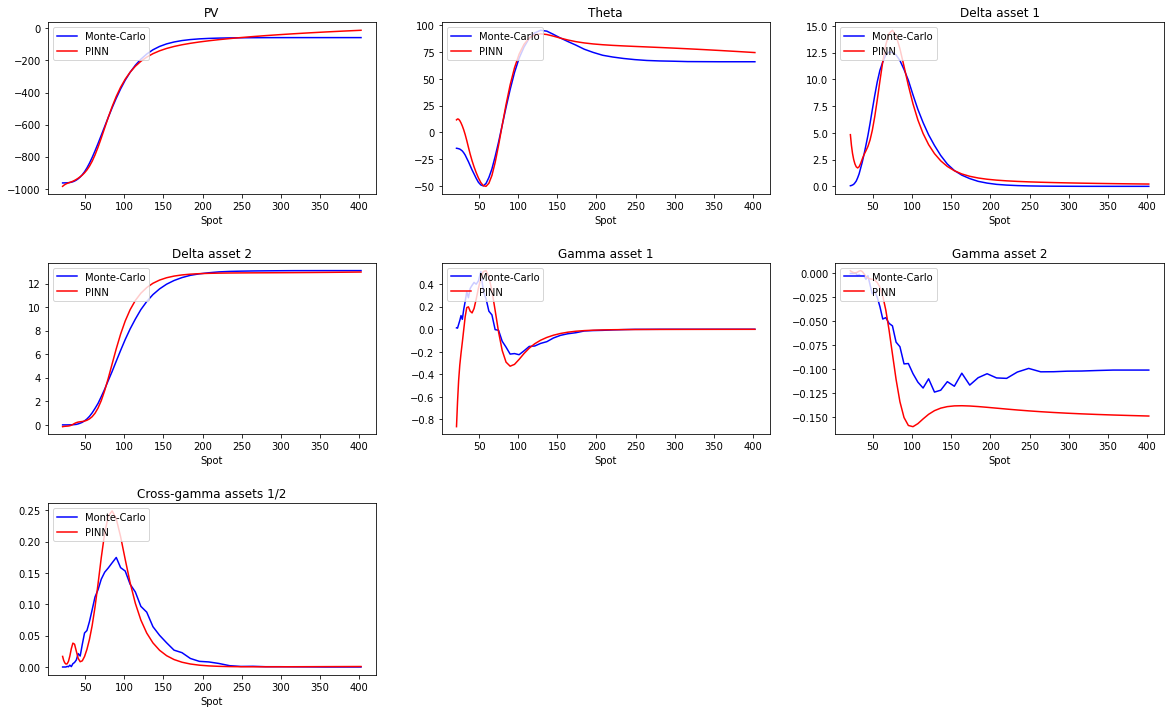

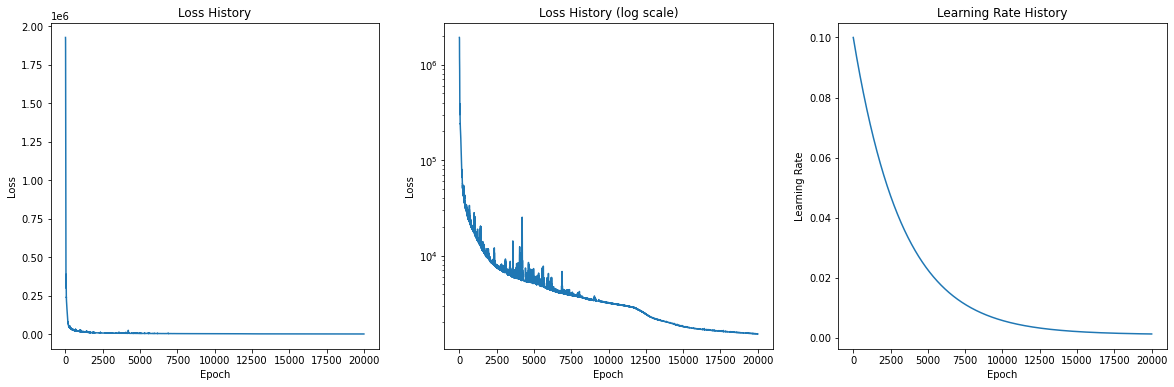

In [115]:
if use_saved_models:
    model_folder = os.path.join(trained_model_folder, model_name)
    print("Loading pre-trained model from folder: " + model_folder)
    model = tf.keras.models.load_model(model_folder)

tpoint = np.asarray([0])
points = [np.concatenate([tpoint, x]) for x in x_space]
md_pv, md_delta, md_theta, md_gamma = eval_model(model, points)

# Calculate rmse
rmse_ = np.sqrt(sk.metrics.mean_squared_error(mc_pv, md_pv))
print("RMSE: " + str(rmse_))

# Plot
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.40)

plt.subplot(3, 3, 1)
plt.title("PV")
plt.xlabel('Spot')
plt.plot(s_ladder, mc_pv, color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_pv, color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 2)
plt.title("Theta")
plt.xlabel('Spot')
plt.plot(s_ladder, mc_theta, color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_theta, color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 3)
plt.title("Delta asset " + str(asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_delta[:, asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_delta[:, asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 4)
plt.title("Delta asset " + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_delta[:, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_delta[:, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 5)
plt.title("Gamma asset " + str(asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, asset_idx, asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, asset_idx, asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 6)
plt.title("Gamma asset " + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, cross_asset_idx, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, cross_asset_idx, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 7)
plt.title("Cross-gamma assets " + str(asset_idx + 1) + "/" + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, asset_idx, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, asset_idx, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.show()

# Plot loss history (if model has been trained here)
if not use_saved_models:
    plt.figure(figsize=(20, 6))
    plt.subplots_adjust(hspace=0.40)
    plt.subplot(1, 3, 1)
    plt.title("Loss History")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1, 3, 2)
    plt.title("Loss History (log scale)")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.yscale("log")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.subplot(1, 3, 3)
    plt.title("Learning Rate History")
    plt.plot(range(len(lr_hist)), lr_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()